In [2]:
import tensorflow as tf
import numpy as np
import cv2

model = tf.keras.models.load_model('C:/Users/Fatma/Downloads/VGG19_Model_Bounded_Box_More_Process.h5')
last_conv_layer_name = 'block5_conv4'  # Or check using model.summary()
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

def preprocess_grayscale_image(image, target_size=(224, 224)):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, target_size)
    image = cv2.fastNlMeansDenoising(image, h=15)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(6, 6))
    image = clahe.apply(image)
    blur = cv2.GaussianBlur(image, (3, 3), 0)
    sharpen_kernel = np.array([[-1, -1, -1],
                               [-1,  9, -1],
                               [-1, -1, -1]])
    image = cv2.filter2D(blur, -1, sharpen_kernel)
    image = image.astype("float32") / 255.0
    image = np.stack((image,) * 3, axis=-1)  # to (224, 224, 3)
    return np.expand_dims(image, axis=0)     # to (1, 224, 224, 3)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def apply_heatmap_and_bbox(original_img, heatmap, threshold=0.4):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    binary_map = np.uint8(heatmap > threshold) * 255

    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_with_box = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return img_with_box

def predict_and_visualize(image):
    input_img = preprocess_grayscale_image(image)
    preds = model.predict(input_img)
    idx = np.argmax(preds[0])
    label = class_names[idx]
    confidence = float(preds[0][idx])

    # Get Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(input_img, model, last_conv_layer_name, idx)
    result_img = apply_heatmap_and_bbox(image, heatmap)

    return result_img, {label: confidence}

def apply_heatmap_overlay(original_img, heatmap, threshold=0.4, alpha=0.5):
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    if len(original_img.shape) == 2:
        original_img_bgr = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)
    else:
        original_img_bgr = original_img.copy()

    overlayed_img = cv2.addWeighted(original_img_bgr, 1 - alpha, heatmap_color, alpha, 0)

    binary_map = np.uint8(heatmap_resized > threshold) * 255
    contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(overlayed_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return overlayed_img


def visualize_gradcam_result(image, use_color=True, threshold=0.4):
    input_img = preprocess_grayscale_image(image)
    preds = model.predict(input_img)
    idx = np.argmax(preds[0])
    label = class_names[idx]
    confidence = float(preds[0][idx])

    heatmap = make_gradcam_heatmap(input_img, model, last_conv_layer_name, idx)

    if use_color:
        result_img = apply_heatmap_overlay(image, heatmap, threshold)
    else:
        result_img = apply_heatmap_and_bbox(image, heatmap, threshold)

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title(f"{label} ({confidence * 100:.2f}%)")
    plt.axis('off')
    plt.show()

    return result_img, {label: confidence}



Color Grad-CAM with bounding box:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step


C:\Users\Fatma\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


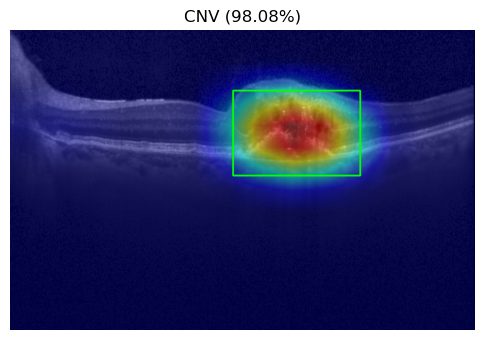


Grayscale + bounding box only:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


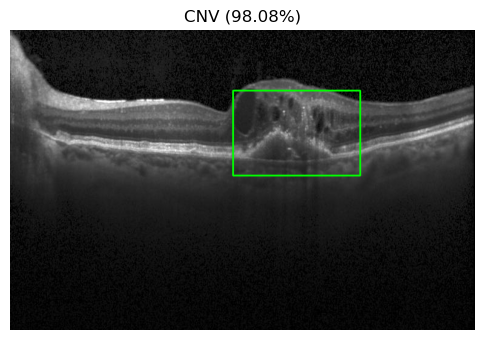

(array([[[26, 26, 26],
         [16, 16, 16],
         [28, 28, 28],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 1,  1,  1]],
 
        [[40, 40, 40],
         [32, 32, 32],
         [40, 40, 40],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[55, 55, 55],
         [50, 50, 50],
         [50, 50, 50],
         ...,
         [ 1,  1,  1],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        ...,
 
        [[ 6,  6,  6],
         [ 7,  7,  7],
         [ 5,  5,  5],
         ...,
         [ 5,  5,  5],
         [ 1,  1,  1],
         [ 0,  0,  0]],
 
        [[ 5,  5,  5],
         [ 8,  8,  8],
         [ 7,  7,  7],
         ...,
         [ 8,  8,  8],
         [ 4,  4,  4],
         [ 0,  0,  0]],
 
        [[ 3,  3,  3],
         [ 8,  8,  8],
         [ 8,  8,  8],
         ...,
         [ 5,  5,  5],
         [ 2,  2,  2],
         [ 0,  0,  0]]], dtype=uint8),
 {'CNV': 0.9808324575424194})

In [3]:
import cv2
from matplotlib import pyplot as plt

# Load your image (grayscale)
image = cv2.imread('C:/Users/Fatma/Desktop/Second Term 2/CV Project/CNV/CNV-53018-1.jpeg', cv2.IMREAD_GRAYSCALE)

# Grad-CAM with color
print("Color Grad-CAM with bounding box:")
visualize_gradcam_result(image, use_color=True)

# Grayscale + bounding box only
print("\nGrayscale + bounding box only:")
visualize_gradcam_result(image, use_color=False)


In [4]:
!pip install gradio

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import gradio as gr
# Gradio Interface Function
def gradcam_gradio_interface(image, use_color):
    try:
        # Convert uploaded image to grayscale if it's RGB
        if image.ndim == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        elif image.ndim != 2:
            raise ValueError("Uploaded image must be grayscale or RGB.")

        result_img, prediction = visualize_gradcam_result(image, use_color=use_color)
        result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)  # Convert for Gradio display
        return result_img, prediction

    except Exception as e:
        print("Error:", e)
        return None, {"Error": str(e)}

# Launch the interface
gr.Interface(
    fn=gradcam_gradio_interface,
    inputs=[
        gr.Image(type="numpy", label="Upload Retinal Image"),
        gr.Checkbox(label="Use Color Overlay Grad-CAM", value=True)
    ],
    outputs=[
        gr.Image(type="numpy", label="Grad-CAM Result"),
        gr.Label(label="Prediction")
    ],
    title="Retinal Disease Detection with Grad-CAM",
    description="Upload a grayscale or RGB OCT image. The model will classify it and show a Grad-CAM explanation."
).launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


C:\Users\Fatma\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
C:\Users\Fatma\AppData\Local\Temp\ipykernel_9608\130209083.py:111: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


C:\Users\Fatma\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
C:\Users\Fatma\AppData\Local\Temp\ipykernel_9608\130209083.py:111: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
